# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

### Import Dog Dataset

In [ ]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
# print('There are %d total dog categories.' % len(dog_names))
# print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
# print('There are %d training dog images.' % len(train_files))
# print('There are %d validation dog images.' % len(valid_files))
# print('There are %d test dog images.'% len(test_files))

### Import Human Dataset

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 5750 total human images.


### Example Detect Humans

Number of faces detected: 1


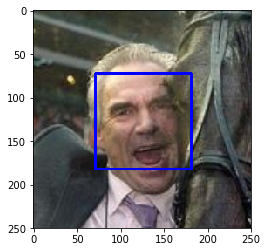

In [8]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

def carregar_img_pasta(img):
    caminho_img = img.split('/')
    return (img + '/' + caminho_img[2] + '_0001.jpg')
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
# load color (BGR) image
# Tinha um erro nessa linha, faltava colocar o nome do arquivo e sua extensão
img = cv2.imread(carregar_img_pasta(human_files[1]))
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# find faces in image
faces = face_cascade.detectMultiScale(gray)
# print number of faces detected in the image
print('Number of faces detected:', len(faces))
# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Write a Human Face Detector

In [9]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

In [10]:
human_files_short = human_files[:100]
print ("** Função para identificar Rosto Humanos **")
contador = 0
for img_humano in human_files_short:
    img = carregar_img_pasta(img_humano)
    if(face_detector(img)):
        contador = contador + 1
print("Humanos Identificados:", contador, "/ 100")
contador = 0   

dog_files_short = train_files[:100]
for img_dog in dog_files_short:
    if(face_detector(img_dog)):
        contador = contador + 1
print("Cachorros Identificados:", contador, "/ 100")

** Função para identificar Rosto Humanos **
Humanos Identificados: 98 / 100
Cachorros Identificados: 11 / 100


### Detect Dogs

In [13]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

In [14]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [15]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

In [16]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

In [17]:
print ("** Função para identificar Rosto Cachorros **")
print ("Testando com a img dos HUMANOS:")
contador = 0

human_files_short = human_files[:100]
for img_humano in human_files_short:
    img = carregar_img_pasta(img_humano)
    if(dog_detector(img)):
        contador = contador + 1

print("Humanos Identificados:", contador, "/ 100")
contador = 0

print("\nTestando com a img dos CACHORROS:")

dog_files_short = train_files[:100]
for img_dog in dog_files_short:
    if(dog_detector(img_dog)):
        contador = contador + 1
print("Cachorros Identificados:", contador, "/ 100")

** Função para identificar Rosto Cachorros **
Testando com a img dos HUMANOS:
Humanos Identificados: 2 / 100

Testando com a img dos CACHORROS:
Cachorros Identificados: 100 / 100


## CNN to Classify Dog Breeds (from Scratch)

### Pre-process the Data

In [26]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# Reduzir o tamanho da entrada pois trava :(
train_tensors = paths_to_tensor(train_files[:1000]).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files[:835]).astype('float32')/255
test_tensors = paths_to_tensor(test_files[:836]).astype('float32')/255

100%|██████████| 836/836 [00:17<00:00, 47.12it/s]


### Model Architecture

In [27]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(9,9), input_shape=(224, 224, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))

model.add(Conv2D(filters=64, kernel_size=(7,7)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same'))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1))
model.add(Dense(500))
model.add(Activation("relu"))
model.add(Dense(133))
model.add(Activation("softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 216, 216, 32)      7808      
_________________________________________________________________
activation_103 (Activation)  (None, 216, 216, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 108, 108, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 102, 102, 64)      100416    
_________________________________________________________________
activation_104 (Activation)  (None, 102, 102, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 102, 102, 64)      0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
__________

### Compile the Model

In [28]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [30]:
from keras.callbacks import ModelCheckpoint  

epochs = 10
salvar_arquivo = 'saved_models/weights.best.from_scratch.hdf5'
checkpointer = ModelCheckpoint( filepath=salvar_arquivo, verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets[:1000], 
          validation_data=(valid_tensors, valid_targets[:835]),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 1000 samples, validate on 835 samples
Epoch 1/10
1000/1000 [==============================] - 508s - loss: 4.9024 - acc: 0.0090 - val_loss: 4.8875 - val_acc: 0.0096
Epoch 2/10
1000/1000 [==============================] - 495s - loss: 4.8784 - acc: 0.0120 - val_loss: 4.8853 - val_acc: 0.0096
Epoch 3/10
1000/1000 [==============================] - 516s - loss: 4.8647 - acc: 0.0130 - val_loss: 4.8947 - val_acc: 0.0060
Epoch 4/10
1000/1000 [==============================] - 500s - loss: 4.8487 - acc: 0.0130 - val_loss: 4.8976 - val_acc: 0.0096
Epoch 5/10
1000/1000 [==============================] - 503s - loss: 4.8570 - acc: 0.0160 - val_loss: 4.8867 - val_acc: 0.0096
Epoch 6/10
1000/1000 [==============================] - 488s - loss: 4.8459 - acc: 0.0140 - val_loss: 4.8877 - val_acc: 0.0096
Epoch 7/10
1000/1000 [==============================] - 516s - loss: 4.8398 - acc: 0.0100 - val_loss: 4.9038 - val_acc: 0.0096
Epoch 8/10
1000/1000 [==============================] - 492s - l

### Load the Model with the Best Validation Loss

In [31]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

In [32]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)

print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 1.3158%


## CNN to Classify Dog Breeds

### Obtain Bottleneck Features

In [33]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

In [34]:
VGG16_model = Sequential()

VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [35]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [36]:
salvar_arquivo = 'saved_models/weights.best.VGG16.hdf5'
checkpointer = ModelCheckpoint( filepath=salvar_arquivo, verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s - loss: 11.9649 - acc: 0.1298 - val_loss: 9.9551 - val_acc: 0.2455
Epoch 2/20
6680/6680 [==============================] - 2s - loss: 9.3131 - acc: 0.3234 - val_loss: 9.2602 - val_acc: 0.3329
Epoch 3/20
6680/6680 [==============================] - 2s - loss: 8.8491 - acc: 0.3874 - val_loss: 8.9639 - val_acc: 0.3725
Epoch 4/20
6680/6680 [==============================] - 2s - loss: 8.6187 - acc: 0.4138 - val_loss: 9.0099 - val_acc: 0.3629
Epoch 5/20
6680/6680 [==============================] - 2s - loss: 8.4465 - acc: 0.4386 - val_loss: 8.7269 - val_acc: 0.3964
Epoch 6/20
6680/6680 [==============================] - 2s - loss: 8.3208 - acc: 0.4512 - val_loss: 8.6256 - val_acc: 0.4108
Epoch 7/20
6680/6680 [==============================] - 2s - loss: 8.1876 - acc: 0.4672 - val_loss: 8.5916 - val_acc: 0.4084
Epoch 8/20
6680/6680 [==============================] - 2s - loss: 8.1347 - a

### Load the Model with the Best Validation Loss

In [37]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

In [38]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 44.1388%


### Predict Dog Breed with the Model

In [39]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    return dog_names[np.argmax(predicted_vector)]

## CNN to Classify Dog Breeds (using Transfer Learning)

### Obtain Bottleneck Features

In [42]:
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_Inception = bottleneck_features['train']
valid_Inception = bottleneck_features['valid']
test_Inception = bottleneck_features['test']

### Model Architecture

In [43]:
Inc_model = Sequential()

Inc_model.add(GlobalAveragePooling2D(input_shape=train_Inception.shape[1:]))
Inc_model.add(Dense(500))
Inc_model.add(Activation("tanh"))
Inc_model.add(Dropout(0.2))
Inc_model.add(Dense(133, activation='softmax'))

Inc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               1024500   
_________________________________________________________________
activation_107 (Activation)  (None, 500)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 133)               66633     
Total params: 1,091,133.0
Trainable params: 1,091,133.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [44]:
Inc_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [ ]:
salvar_arquivo = 'saved_models/weights.best.Inc_model.hdf5'

checkpointer = ModelCheckpoint( filepath=salvar_arquivo, verbose=1, save_best_only=True)

Inc_model.fit(train_Inception, train_targets, 
          validation_data=(valid_Inception, valid_targets),
          epochs=2000, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/2000
6680/6680 [==============================] - 10s - loss: 1.4215 - acc: 0.6563 - val_loss: 0.8283 - val_acc: 0.7593
Epoch 2/2000
6680/6680 [==============================] - 9s - loss: 0.6257 - acc: 0.8163 - val_loss: 0.6789 - val_acc: 0.7916
Epoch 3/2000
6680/6680 [==============================] - 9s - loss: 0.4897 - acc: 0.8484 - val_loss: 0.6769 - val_acc: 0.8120
Epoch 4/2000
6680/6680 [==============================] - 9s - loss: 0.3911 - acc: 0.8787 - val_loss: 0.6770 - val_acc: 0.8108
Epoch 5/2000
6680/6680 [==============================] - 9s - loss: 0.3327 - acc: 0.8981 - val_loss: 0.5750 - val_acc: 0.8359
Epoch 6/2000
6680/6680 [==============================] - 9s - loss: 0.2728 - acc: 0.9150 - val_loss: 0.6219 - val_acc: 0.8275
Epoch 7/2000
6680/6680 [==============================] - 9s - loss: 0.2207 - acc: 0.9317 - val_loss: 0.6072 - val_acc: 0.8251
Epoch 8/2000
6680/6680 [==============================] - 9s - 

6680/6680 [==============================] - 9s - loss: 0.0167 - acc: 0.9979 - val_loss: 1.0459 - val_acc: 0.8527
Epoch 66/2000
6680/6680 [==============================] - 9s - loss: 0.0139 - acc: 0.9969 - val_loss: 1.0458 - val_acc: 0.8383
Epoch 67/2000
6680/6680 [==============================] - 9s - loss: 0.0129 - acc: 0.9973 - val_loss: 1.0121 - val_acc: 0.8455
Epoch 68/2000
6680/6680 [==============================] - 9s - loss: 0.0149 - acc: 0.9973 - val_loss: 1.1408 - val_acc: 0.8455
Epoch 69/2000
6680/6680 [==============================] - 9s - loss: 0.0141 - acc: 0.9966 - val_loss: 1.0592 - val_acc: 0.8455
Epoch 70/2000
6680/6680 [==============================] - 9s - loss: 0.0108 - acc: 0.9975 - val_loss: 1.0422 - val_acc: 0.8467
Epoch 71/2000
6680/6680 [==============================] - 9s - loss: 0.0130 - acc: 0.9972 - val_loss: 1.0304 - val_acc: 0.8491
Epoch 72/2000
6680/6680 [==============================] - 9s - loss: 0.0129 - acc: 0.9972 - val_loss: 1.0908 - val_ac

### Load the Model with the Best Validation Loss

In [ ]:
Inc_model.load_weights('saved_models/weights.best.Inc_model.hdf5')

### Test the Model

In [ ]:
Inc_predictions = [np.argmax(Inc_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Inception]

test_accuracy = 100*np.sum(np.array(Inc_predictions)==np.argmax(test_targets, axis=1))/len(Inc_predictions)

print('Test accuracy: %.4f%%' % test_accuracy)

### Predict Dog Breed with the Model

In [ ]:
def Inc_predict_breed(img_path):
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    predicted_vector = Inc_model.predict(bottleneck_feature)
    return dog_names[np.argmax(predicted_vector)]

## Step 6: Write your Algorithm

### Write your Algorithm

In [3]:
class NeitherDogNorHumanError(Exception):
    """Subclassing Error for clarity"""
    pass

def predict_breed_or_resemblance(img_path):
    creature = None
    message = None
    breed = None
    if dog_detector(img_path):
        creature = "dog"
        message = "your predicted breed is"
    
    if face_detector(img_path):
        creature = "human"
        message = "you look like a"
    
    if not creature:
        raise NeitherDogNorHumanError("Tis neither a dog nor a human!!!")
    
    breed = Inc_predict_breed(img_path)
    return "Hello, {}! {} ... {}".format(creature, message, breed)

### Test Algorithm

In [2]:
caminho_img_teste = ''
# print(predict_breed_or_resemblance(caminho_img_teste))